## Teaching GPT multiple tasks at once with prompt engineering

In [94]:
from transformers import Trainer, TrainingArguments, DataCollatorForLanguageModeling, GPT2LMHeadModel, pipeline, \
                         GPT2Tokenizer
import pandas as pd
from datasets import Dataset

In [95]:
# https://www.kaggle.com/snap/amazon-fine-food-reviews?select=Reviews.csv

reviews = pd.read_csv('../data/reviews.csv')

print(reviews.shape)

reviews.head()

(96512, 3)


,Text,Summary,Score
0,Great taffy at a great price. There was a wid...,Great taffy,5
1,This taffy is so good. It is very soft and ch...,"Wonderful, tasty taffy",5
2,Right now I'm mostly just sprouting this so my...,Yay Barley,5
3,This is a very healthy dog food. Good for thei...,Healthy Dog Food,5
4,good flavor! these came securely packed... the...,fresh and greasy!,4


<AxesSubplot:title={'center':'Histogram of Review Length'}, ylabel='Frequency'>

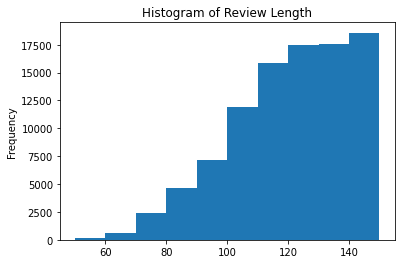

In [96]:
reviews['Text'].str.len().plot(kind='hist', title='Histogram of Review Length')

<AxesSubplot:title={'center':'Histogram of Summary Length'}, ylabel='Frequency'>

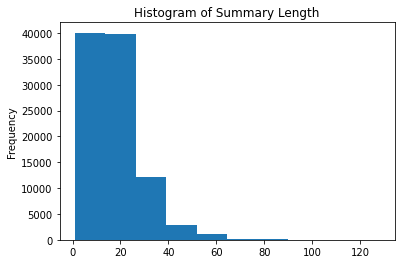

In [97]:
reviews['Summary'].str.len().plot(kind='hist', title='Histogram of Summary Length')

<AxesSubplot:title={'center':'Histogram of Summary Length'}, ylabel='Frequency'>

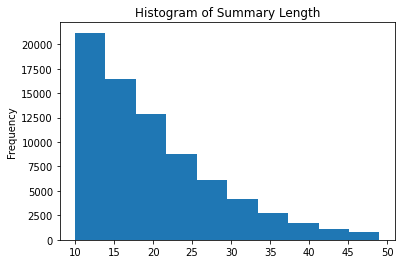

In [98]:
# remove very short and very long summaries
reviews = reviews[(reviews['Summary'].str.len() >= 10) & (reviews['Summary'].str.len() < 50)]

reviews['Summary'].str.len().plot(kind='hist', title='Histogram of Summary Length')

<AxesSubplot:>

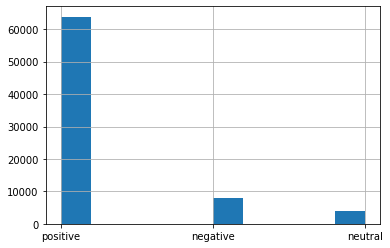

In [100]:
reviews['Sentiment'] = reviews['Score'].map(lambda x: 'positive' if x >= 4 else 'neutral' if x == 3 else 'negative')

reviews['Sentiment'].hist()


In [101]:
# Take 4,000 examples from each sentiment group
reviews = reviews.groupby('Sentiment', group_keys=False).apply(lambda x: x.sample(4000))

In [7]:
reviews.shape

(12000, 4)

<AxesSubplot:>

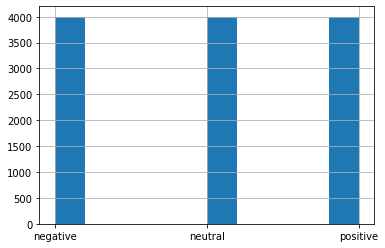

In [8]:
reviews['Sentiment'].hist()

In [9]:
MODEL = 'distilgpt2'

tokenizer = GPT2Tokenizer.from_pretrained(MODEL)

tokenizer.pad_token = tokenizer.eos_token

#add two prompts, one for each task
SENTIMENT_PROMPT = 'Sentiment Task'
SUMMARIZE_PROMPT = 'Summarize Task'
SENTIMENT_TOKEN = '\nSentiment:'
SUMMARIZE_TOKEN = '\nSummarize:'


In [10]:
reviews['sentiment_text'] = f'{SENTIMENT_PROMPT}\nReview: ' + reviews['Text'] + SENTIMENT_TOKEN +  ' ' + reviews['Sentiment'].astype(str)

reviews['summarize_text'] = f'{SUMMARIZE_PROMPT}\nReview: ' + reviews['Text'] + SUMMARIZE_TOKEN +  ' ' + reviews['Summary'].astype(str)


In [11]:
reviews['sentiment_text'].head(2).tolist()

['Sentiment Task\nReview: I puchase regular soda because I am allergic to artificial sweeteners. Why is there artificial sweetener in a regular soda syrup?\nSentiment: negative',
 'Sentiment Task\nReview: Kettle chips now look, feel and taste like Lays.  These chips used to be my favorite when it was crinkle cut and hefty.  Now, no longer my favorite.\nSentiment: negative']

In [12]:
print('Sentiment Task\nReview: I just made this for lunch. It had almost no flavor, although it smelled heavenly for the first few minutes of cooking.\nSentiment: negative')

Sentiment Task
Review: I just made this for lunch. It had almost no flavor, although it smelled heavenly for the first few minutes of cooking.
Sentiment: negative


In [13]:
reviews['summarize_text'].head(2).tolist()

['Summarize Task\nReview: I puchase regular soda because I am allergic to artificial sweeteners. Why is there artificial sweetener in a regular soda syrup?\nSummarize: It has splenda in it',
 "Summarize Task\nReview: Kettle chips now look, feel and taste like Lays.  These chips used to be my favorite when it was crinkle cut and hefty.  Now, no longer my favorite.\nSummarize: Surprise 1  It's different..."]

In [14]:
print('Summarize Task\nReview: I just made this for lunch. It had almost no flavor, although it smelled heavenly for the first few minutes of cooking.\nSummarize: Not bad, but bland')

Summarize Task
Review: I just made this for lunch. It had almost no flavor, although it smelled heavenly for the first few minutes of cooking.
Summarize: Not bad, but bland


In [15]:
reviews = reviews.sample(frac=1)

training_examples = reviews['summarize_text'].tolist() + reviews['sentiment_text'].tolist()

# 24,000 = 2 prompts per 4,000 examples from the 3 sentiment groups
print(len(training_examples))

24000


In [16]:
multi_task_df = pd.DataFrame({'text': training_examples})

data = Dataset.from_pandas(multi_task_df)

def preprocess(examples):
    return tokenizer(examples['text'], truncation=True)

data = data.map(preprocess, batched=True)

data = data.train_test_split(train_size=.9)

  0%|          | 0/24 [00:00<?, ?ba/s]

In [17]:
model = GPT2LMHeadModel.from_pretrained(MODEL)

In [18]:
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

In [19]:
training_args = TrainingArguments(
    output_dir="./gpt2_multitask", #The output directory
    overwrite_output_dir=True, #overwrite the content of the output directory
    num_train_epochs=5, # number of training epochs
    per_device_train_batch_size=32, # batch size for training
    per_device_eval_batch_size=32,  # batch size for evaluation
    logging_steps=50,
    load_best_model_at_end=True,
    evaluation_strategy='epoch',
    save_strategy='epoch'
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=data['train'],
    eval_dataset=data['test'],
    data_collator=data_collator
)

trainer.evaluate()

The following columns in the evaluation set  don't have a corresponding argument in `GPT2LMHeadModel.forward` and have been ignored: text.
***** Running Evaluation *****
  Num examples = 2400
  Batch size = 32


{'eval_loss': 5.012480735778809,
 'eval_runtime': 39.0493,
 'eval_samples_per_second': 61.461,
 'eval_steps_per_second': 1.921}

In [20]:
trainer.train()

The following columns in the training set  don't have a corresponding argument in `GPT2LMHeadModel.forward` and have been ignored: text.
/opt/homebrew/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 21600
  Num Epochs = 5
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 3375


Epoch,Training Loss,Validation Loss
1,2.700400,2.573740
2,2.472700,2.426244
3,2.356300,2.341945
4,2.255800,2.296094
5,2.232900,2.279544


The following columns in the evaluation set  don't have a corresponding argument in `GPT2LMHeadModel.forward` and have been ignored: text.
***** Running Evaluation *****
  Num examples = 2400
  Batch size = 32
Saving model checkpoint to ./gpt2_multitask/checkpoint-675
Configuration saved in ./gpt2_multitask/checkpoint-675/config.json
Model weights saved in ./gpt2_multitask/checkpoint-675/pytorch_model.bin
The following columns in the evaluation set  don't have a corresponding argument in `GPT2LMHeadModel.forward` and have been ignored: text.
***** Running Evaluation *****
  Num examples = 2400
  Batch size = 32
Saving model checkpoint to ./gpt2_multitask/checkpoint-1350
Configuration saved in ./gpt2_multitask/checkpoint-1350/config.json
Model weights saved in ./gpt2_multitask/checkpoint-1350/pytorch_model.bin
The following columns in the evaluation set  don't have a corresponding argument in `GPT2LMHeadModel.forward` and have been ignored: text.
***** Running Evaluation *****
  Num exa

TrainOutput(global_step=3375, training_loss=2.45722078789605, metrics={'train_runtime': 6263.2394, 'train_samples_per_second': 17.243, 'train_steps_per_second': 0.539, 'total_flos': 1588986367967232.0, 'train_loss': 2.45722078789605, 'epoch': 5.0})

In [21]:
trainer.evaluate()

The following columns in the evaluation set  don't have a corresponding argument in `GPT2LMHeadModel.forward` and have been ignored: text.
***** Running Evaluation *****
  Num examples = 2400
  Batch size = 32


{'eval_loss': 2.2795443534851074,
 'eval_runtime': 37.0317,
 'eval_samples_per_second': 64.809,
 'eval_steps_per_second': 2.025,
 'epoch': 5.0}

In [22]:
trainer.save_model()

Saving model checkpoint to ./gpt2_multitask
Configuration saved in ./gpt2_multitask/config.json
Model weights saved in ./gpt2_multitask/pytorch_model.bin


In [23]:
loaded_model = GPT2LMHeadModel.from_pretrained('./gpt2_multitask')

generator = pipeline('text-generation', model=loaded_model, tokenizer=tokenizer)

loading configuration file ./gpt2_multitask/config.json
Model config GPT2Config {
  "_name_or_path": "distilgpt2",
  "_num_labels": 1,
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0
  },
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_inner": null,
  "n_layer": 6,
  "n_positions": 1024,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "task_specific_params": {
    "text-generation": {
      "do_sample": true,
      "max_length": 50
    }
  },
  "torch_dtype": "f

In [36]:
text_sample, score, summary = reviews.sample(1)[['Text', 'Sentiment', 'Summary']].values[0]

print(text_sample)
print(score)
print(summary)

num_tokens = len(tokenizer(text_sample)['input_ids'])
num_tokens

Second item you can't trust Amazon calling "gluten free".  What do they think hydrolyzed corn soy WHEAT GLUTEN protein is?
negative
HAS GLUTEN IN IT!!!!!


32

In [37]:
sentiment_text_sample = f'{SENTIMENT_PROMPT}\nReview: {text_sample}{SENTIMENT_TOKEN}'
summarize_text_sample = f'{SUMMARIZE_PROMPT}\nReview: {text_sample}{SUMMARIZE_TOKEN}'

In [38]:
print(sentiment_text_sample)

Sentiment Task
Review: Second item you can't trust Amazon calling "gluten free".  What do they think hydrolyzed corn soy WHEAT GLUTEN protein is?
Sentiment:


In [39]:
print(summarize_text_sample)

Summarize Task
Review: Second item you can't trust Amazon calling "gluten free".  What do they think hydrolyzed corn soy WHEAT GLUTEN protein is?
Summarize:


In [40]:
for generated_text in generator(sentiment_text_sample, num_return_sequences=1, max_length=num_tokens + 1):
    print(generated_text['generated_text'])

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 42, but ``max_length`` is set to 33. This can lead to unexpected behavior. You should consider increasing ``config.max_length`` or ``max_length``.


Sentiment Task
Review: Second item you can't trust Amazon calling "gluten free".  What do they think hydrolyzed corn soy WHEAT GLUTEN protein is?
Sentiment: negative


In [41]:
for generated_text in generator(summarize_text_sample, num_return_sequences=3, max_length=num_tokens + 20):
    print(generated_text['generated_text'])
    print('----')

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Summarize Task
Review: Second item you can't trust Amazon calling "gluten free".  What do they think hydrolyzed corn soy WHEAT GLUTEN protein is?
Summarize: Gluten free!?  They're lying
----
Summarize Task
Review: Second item you can't trust Amazon calling "gluten free".  What do they think hydrolyzed corn soy WHEAT GLUTEN protein is?
Summarize: Corn Thins...What can they say
----
Summarize Task
Review: Second item you can't trust Amazon calling "gluten free".  What do they think hydrolyzed corn soy WHEAT GLUTEN protein is?
Summarize: Gluten Free Corn Protein!
Sum
----


In [77]:
# Trying with a non-finetuned GPT2 to see the style difference

In [78]:
non_fintuned_generator = pipeline(
    'text-generation', model=GPT2LMHeadModel.from_pretrained('gpt2'), tokenizer=tokenizer
)

loading configuration file https://huggingface.co/gpt2/resolve/main/config.json from cache at /Users/sinanozdemir/.cache/huggingface/transformers/fc674cd6907b4c9e933cb42d67662436b89fa9540a1f40d7c919d0109289ad01.7d2e0efa5ca20cef4fb199382111e9d3ad96fd77b849e1d4bed13a66e1336f51
Model config GPT2Config {
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_inner": null,
  "n_layer": 12,
  "n_positions": 1024,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "task_specific_params": {
    "text-gen

In [79]:
for generated_text in non_fintuned_generator(sentiment_text_sample, num_return_sequences=5, max_length=num_tokens + 1):
    print(generated_text['generated_text'])
    print('-------')

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 42, but ``max_length`` is set to 33. This can lead to unexpected behavior. You should consider increasing ``config.max_length`` or ``max_length``.


Sentiment Task
Review: Second item you can't trust Amazon calling "gluten free".  What do they think hydrolyzed corn soy WHEAT GLUTEN protein is?
Sentiment: My
-------
Sentiment Task
Review: Second item you can't trust Amazon calling "gluten free".  What do they think hydrolyzed corn soy WHEAT GLUTEN protein is?
Sentiment: Third
-------
Sentiment Task
Review: Second item you can't trust Amazon calling "gluten free".  What do they think hydrolyzed corn soy WHEAT GLUTEN protein is?
Sentiment: First
-------
Sentiment Task
Review: Second item you can't trust Amazon calling "gluten free".  What do they think hydrolyzed corn soy WHEAT GLUTEN protein is?
Sentiment: "
-------
Sentiment Task
Review: Second item you can't trust Amazon calling "gluten free".  What do they think hydrolyzed corn soy WHEAT GLUTEN protein is?
Sentiment: Product
-------


In [80]:
for generated_text in non_fintuned_generator(summarize_text_sample, num_return_sequences=3, max_length=num_tokens + 20):
    print(generated_text['generated_text'])
    print('----')

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Summarize Task
Review: Second item you can't trust Amazon calling "gluten free".  What do they think hydrolyzed corn soy WHEAT GLUTEN protein is?
Summarize: I know what you're thinking. I
----
Summarize Task
Review: Second item you can't trust Amazon calling "gluten free".  What do they think hydrolyzed corn soy WHEAT GLUTEN protein is?
Summarize: I haven't had this problem on my
----
Summarize Task
Review: Second item you can't trust Amazon calling "gluten free".  What do they think hydrolyzed corn soy WHEAT GLUTEN protein is?
Summarize: First item you don't trust. 
----


In [104]:
for generated_text in non_fintuned_generator(f'Summarization Task\n{text_sample}\nTL;DR:', num_return_sequences=3, max_length=num_tokens + 20):
    print(generated_text['generated_text'])
    print('----')

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Summarization Task
Second item you can't trust Amazon calling "gluten free".  What do they think hydrolyzed corn soy WHEAT GLUTEN protein is?
TL;DR: soy sauce, corn oil, and water in a
----
Summarization Task
Second item you can't trust Amazon calling "gluten free".  What do they think hydrolyzed corn soy WHEAT GLUTEN protein is?
TL;DR: What are they doing to people who have celiac
----
Summarization Task
Second item you can't trust Amazon calling "gluten free".  What do they think hydrolyzed corn soy WHEAT GLUTEN protein is?
TL;DR: They said wheat wheat wheat but how about
----
